In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [100]:
df = pd.read_csv('data.csv')
df.head()

,ID,air_time1,disp_index1,gmrt_in_air1,gmrt_on_paper1,max_x_extension1,max_y_extension1,mean_acc_in_air1,mean_acc_on_paper1,mean_gmrt1,...,mean_jerk_in_air25,mean_jerk_on_paper25,mean_speed_in_air25,mean_speed_on_paper25,num_of_pendown25,paper_time25,pressure_mean25,pressure_var25,total_time25,class
0,id_1,5160,0.000013,120.804174,86.853334,957,6601,0.361800,0.217459,103.828754,...,0.141434,0.024471,5.596487,3.184589,71,40120,1749.278166,296102.7676,144605,P
1,id_2,51980,0.000016,115.318238,83.448681,1694,6998,0.272513,0.144880,99.383459,...,0.049663,0.018368,1.665973,0.950249,129,126700,1504.768272,278744.2850,298640,P
2,id_3,2600,0.000010,229.933997,172.761858,2333,5802,0.387020,0.181342,201.347928,...,0.178194,0.017174,4.000781,2.392521,74,45480,1431.443492,144411.7055,79025,P
3,id_4,2130,0.000010,369.403342,183.193104,1756,8159,0.556879,0.164502,276.298223,...,0.113905,0.019860,4.206746,1.613522,123,67945,1465.843329,230184.7154,181220,P
4,id_5,2310,0.000007,257.997131,111.275889,987,4732,0.266077,0.145104,184.636510,...,0.121782,0.020872,3.319036,1.680629,92,37285,1841.702561,158290.0255,72575,P


In [101]:
# Drops the objects columns from the dataset
X = df.drop(['class', 'ID'], axis='columns')
y = df['class'].map({'P': 1, 'H': 0})

In [102]:
X_scaled = StandardScaler().fit_transform(X)

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [104]:
forest = RandomForestClassifier(n_estimators=100, random_state=42)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [105]:
forest.score(X_test, y_test)

0.8857142857142857

In [ ]:
forest.feature_importances_

In [107]:
feature_imp_df = pd.DataFrame({'Feature': X.columns, 'Gini Importance': forest.feature_importances_}).sort_values('Gini Importance', ascending=False) 
print(feature_imp_df)

                  Feature  Gini Importance
413          total_time23         0.038206
269          total_time15         0.036744
252            air_time15         0.030857
107           total_time6         0.023561
396            air_time23         0.021524
..                    ...              ...
64    mean_jerk_on_paper4         0.000000
279    mean_jerk_in_air16         0.000000
273       gmrt_on_paper16         0.000000
66   mean_speed_on_paper4         0.000000
285       pressure_mean16         0.000000

[450 rows x 2 columns]


In [108]:
THRESHOLD = 0.005
count = 0

for index, row in feature_imp_df.iterrows():
    if row['Gini Importance'] < THRESHOLD:
        count += 1

print(count)

398


In [109]:
X_new = X.drop(feature_imp_df[feature_imp_df['Gini Importance'] < THRESHOLD]['Feature'], axis='columns')

In [110]:
X_new.head()

,air_time1,gmrt_on_paper1,air_time2,total_time2,air_time3,max_y_extension3,mean_jerk_in_air3,total_time3,pressure_mean4,air_time5,...,air_time22,mean_speed_on_paper22,total_time22,air_time23,disp_index23,mean_speed_in_air23,mean_speed_on_paper23,total_time23,gmrt_in_air25,paper_time25
0,5160,86.853334,6085,24870,4345,765,0.125262,15645,1982.085547,66034,...,13215,2.982744,18185,10965,0.000009,2.453629,3.183865,16160,279.628181,40120
1,51980,83.448681,10515,26100,15885,2386,0.161044,27850,1992.516720,12875,...,18555,0.859578,33890,14660,0.000011,1.806707,0.782637,29900,86.117902,126700
2,2600,172.761858,560,7105,420,266,0.026745,5530,1842.092009,680,...,7425,2.388018,12930,7330,0.000011,2.415460,2.730515,13865,215.379542,45480
3,2130,183.193104,13735,27255,3795,966,0.039607,13555,1939.577808,10735,...,8989,1.813868,16079,7205,0.000010,4.231579,2.666430,13585,207.557650,67945
4,2310,111.275889,4225,12550,2255,317,0.029026,11815,1982.517149,1050,...,3775,2.020428,8835,5340,0.000008,1.873943,2.154279,10145,167.510556,37285


In [111]:
X_new_scaled = StandardScaler().fit_transform(X_new)

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import f1_score
import pickle
# Split the data into train and test sets
test_size = 0.2  # Proportion of data to allocate to the test set
random_state = 42  # Seed for reproducibility
depths = [3, 4, 5, 6, 7]

In [ ]:
data = X_scaled
scores = []
max_f1 = 0

for random_state in range(1, 20):

    X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=test_size, random_state=random_state)

    for depth in depths:
        clf = DecisionTreeClassifier(random_state=random_state, max_depth=depth)
        clf = clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        #scores.append(score)

        y_pred = clf.predict(X_test)
        f1 = f1_score(y_test, y_pred)
        scores.append(f1)

        if max_f1 < f1:
            max_f1 = f1
            with open('model.pkl', 'wb') as file:
                pickle.dump(clf, file)

print("")
print(f"Number of features {data.shape[1]}")
print(f"Max f1 score: {np.max(scores):.2f}")

#clf = pickle.load(open('model.pkl', 'rb'))
#print(f"Best model accuracy {clf.score(X_test, y_test):.2f}")
#plot_tree(clf, feature_names=X_new.columns, class_names=['H', 'P'], filled=True)
#plt.savefig('reduced_tree.pdf')


Number of features 450
Max f1 score: 0.90


In [ ]:
data = X_new_scaled
scores = []
max_f1 = 0

for random_state in range(1, 20):

    X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=test_size, random_state=random_state)

    for depth in depths:
        clf = DecisionTreeClassifier(random_state=random_state, max_depth=depth)
        clf = clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        #scores.append(score)

        y_pred = clf.predict(X_test)
        f1 = f1_score(y_test, y_pred)
        scores.append(f1)

        if max_f1 < f1:
            max_f1 = f1
            with open('model.pkl', 'wb') as file:
                pickle.dump(clf, file)

print("")
print(f"Number of features {data.shape[1]}")
print(f"Max f1 score: {np.max(scores):.2f}")

#clf = pickle.load(open('model.pkl', 'rb'))
#print(f"Best model accuracy {clf.score(X_test, y_test):.2f}")
#plot_tree(clf, feature_names=X_new.columns, class_names=['H', 'P'], filled=True)
#plt.savefig('reduced_tree.pdf')


Number of features 52
Max f1 score: 0.93



Number of features 52
Max f1 score: 0.93
Best model accuracy 0.94


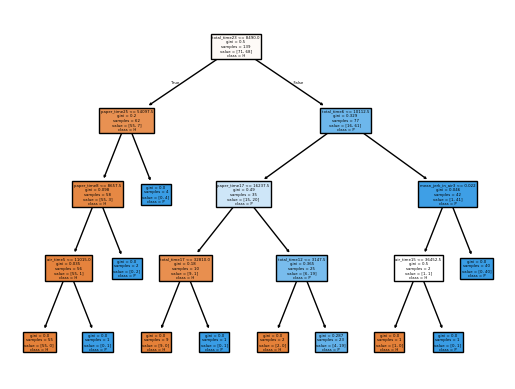

In [ ]:
data = X_new
scores = []
max_f1 = 0

for random_state in range(1, 20):

    X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=test_size, random_state=random_state)

    for depth in depths:
        clf = DecisionTreeClassifier(random_state=random_state, max_depth=depth)
        clf = clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        #scores.append(score)

        y_pred = clf.predict(X_test)
        f1 = f1_score(y_test, y_pred)
        scores.append(f1)

        if max_f1 < f1:
            max_f1 = f1
            with open('model.pkl', 'wb') as file:
                pickle.dump(clf, file)

print("")
print(f"Number of features {data.shape[1]}")
print(f"Max f1 score: {np.max(scores):.2f}")

clf = pickle.load(open('model.pkl', 'rb'))
print(f"Best model accuracy {clf.score(X_test, y_test):.2f}")
plot_tree(clf, feature_names=X_new.columns, class_names=['H', 'P'], filled=True)
plt.savefig('out.pdf')